In [1]:
from paretoGraphRestaurants import *

import pickle
import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

In [2]:
# function to sample numItems from the dataset
def sample_dataset(simMatrix, graphMat, item_ids, numItems):
    '''
    Samples a subset of items from the dataset.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        graphMat (np.ndarray): Graph distance matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        numItems (int): Number of items to sample.
    Returns:
        sampled_simMatrix (np.ndarray): Sampled similarity matrix of shape (numItems, numItems).
        sampled_graphMat (np.ndarray): Sampled graph distance matrix of shape (numItems, numItems).
        sampled_item_ids (list): List of sampled item IDs of length numItems.
    '''
    if numItems is None or numItems <= 0 or numItems >= len(item_ids):
        return simMatrix, graphMat, item_ids
    sampled_indices = np.random.choice(len(item_ids), size=numItems, replace=False)
    sampled_simMatrix = simMatrix[np.ix_(sampled_indices, sampled_indices)]
    sampled_graphMat = graphMat[np.ix_(sampled_indices, sampled_indices)]
    sampled_item_ids = [item_ids[i] for i in sampled_indices]
    return sampled_simMatrix, sampled_graphMat, sampled_item_ids

### Yelp - Average plotting across different random samples

In [3]:
def findApproximateParetoSolutionsRestaurantsGraph(simMatrix, graphMat, item_ids, sample_size, num_samples=10, maxDiameter=None, dataset_name=""):
    '''
    Run graph-diameter algorithms over multiple random samples, aggregate results, and plot mean +/- std.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        graphMat (np.ndarray): Graph distance matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        sample_size (int): Number of items to sample from the dataset.
        num_samples (int): Number of random samples to run.
        maxDiameter (float | None): Maximum diameter for plotting grid. If None, inferred from graphMat.
        dataset_name (str | None): Optional dataset name for output file naming.
    '''
    if maxDiameter is None:
        maxDiameter = float(np.max(graphMat)) if np.asarray(graphMat).size > 0 else 1.0

    # Diameter grid (same for all samples)
    num_steps, min_diameter = 15, 0.0
    diameter_arr = np.linspace(min_diameter, maxDiameter, num_steps)

    algo_names = ["C-Greedy-Diameter", "PruneGraph", "DistanceGreedy", "TopK-degree"]

    def align_to_diameter_arr(diameters, objs):
        if len(diameters) == 0 or len(objs) == 0:
            return np.zeros_like(diameter_arr, dtype=float)
        diameters = np.array(diameters, dtype=float)
        objs = np.array(objs, dtype=float)
        min_len = min(len(diameters), len(objs))
        diameters = diameters[:min_len]
        objs = objs[:min_len]
        agg = {}
        for d, o in zip(diameters, objs):
            if d in agg:
                agg[d] = max(agg[d], o)
            else:
                agg[d] = o
        if len(agg) == 0:
            return np.zeros_like(diameter_arr, dtype=float)
        diameters_sorted = np.array(sorted(agg.keys()), dtype=float)
        objs_sorted = np.array([agg[d] for d in diameters_sorted], dtype=float)
        return np.interp(diameter_arr, diameters_sorted, objs_sorted, left=objs_sorted[0], right=objs_sorted[-1])

    all_objectives = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}

    cgreedy_size_counts = []
    prune_size_counts = []
    distance_size_counts = []
    topk_size_counts = []

    for _ in range(num_samples):
        sampled_sim, sampled_graph, sampled_ids = sample_dataset(simMatrix, graphMat, item_ids, sample_size)
        dist_mat = sampled_graph

        sample_objectives = {alg: [] for alg in algo_names}
        sample_runtimes = {alg: [] for alg in algo_names}

        pareto = paretoGraphRestaurants(n_items=sampled_ids, simMatrix=sampled_sim, pairwise_costs=dist_mat)

        diameters, best_objs, _, _, runTime = pareto.ParetoGreedyDiameter()
        sample_objectives['C-Greedy-Diameter'] = list(align_to_diameter_arr(diameters, best_objs))
        sample_runtimes['C-Greedy-Diameter'].append(runTime)
        cgreedy_size_counts.append(len(diameters))

        pg_diam, pg_objs, _, _, pg_time = pareto.plainGreedyDistanceScaled()
        sample_objectives['DistanceGreedy'] = list(align_to_diameter_arr(pg_diam, pg_objs))
        sample_runtimes['DistanceGreedy'].append(pg_time)
        distance_size_counts.append(len(pg_diam))

        tk_diam, tk_objs, _, _, tk_time = pareto.topKDegree()
        sample_objectives['TopK-degree'] = list(align_to_diameter_arr(tk_diam, tk_objs))
        sample_runtimes['TopK-degree'].append(tk_time)
        topk_size_counts.append(len(tk_diam))

        pr_radii, pr_objs, _, _, pr_time = pareto.graphPruning()
        sample_objectives['PruneGraph'] = list(align_to_diameter_arr(pr_radii, pr_objs))
        sample_runtimes['PruneGraph'].append(pr_time)
        prune_size_counts.append(len(pr_radii))

        for alg in algo_names:
            arr = np.array(sample_objectives[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros_like(diameter_arr, dtype=float)
            all_objectives[alg].append(arr)
            runtimes = sample_runtimes.get(alg, [])
            total_runtime = float(np.nansum(np.array(runtimes, dtype=float))) if len(runtimes) > 0 else 0.0
            all_runtimes[alg].append(total_runtime)

    mean_objectives = {}
    std_objectives = {}
    for alg in algo_names:
        stacked = np.vstack(all_objectives[alg])
        mean_objectives[alg] = np.mean(stacked, axis=0)
        std_objectives[alg] = np.std(stacked, axis=0)

    mean_cgreedy_size = float(np.mean(cgreedy_size_counts)) if len(cgreedy_size_counts) > 0 else 0.0
    mean_prune_size = float(np.mean(prune_size_counts)) if len(prune_size_counts) > 0 else 0.0
    mean_distance_size = float(np.mean(distance_size_counts)) if len(distance_size_counts) > 0 else 0.0
    mean_topk_size = float(np.mean(topk_size_counts)) if len(topk_size_counts) > 0 else 0.0

    mean_frontier_sizes = {
        "C-Greedy-Diameter": mean_cgreedy_size,
        "PruneGraph": mean_prune_size,
        "DistanceGreedy": mean_distance_size,
        "TopK-degree": mean_topk_size,
    }

    tab10_colors = plt.get_cmap("tab10").colors
    color_map = {
        "C-Greedy-Diameter": tab10_colors[2],
        "PruneGraph": tab10_colors[3],
        "DistanceGreedy": tab10_colors[1],
        "TopK-degree": tab10_colors[0],
    }
    marker_map = {
        "C-Greedy-Diameter": "X",
        "PruneGraph": "o",
        "DistanceGreedy": "s",
        "TopK-degree": "^",
    }
    linestyle_map = {
        "C-Greedy-Diameter": (0, (3, 2)),
        "PruneGraph": (0, (4, 2)),
        "DistanceGreedy": (0, (2, 2)),
        "TopK-degree": (0, (1, 1)),
    }

    fig, ax = plt.subplots(figsize=(9, 5.5))
    rng = np.random.default_rng()

    def pick_marker_positions(count):
        if count <= 0:
            return np.array([], dtype=float)
        count = int(max(2, np.round(count)))
        if diameter_arr.size == 0:
            return np.array([], dtype=float)
        d_min = float(diameter_arr.min())
        d_max = float(diameter_arr.max())
        if count == 1 or d_max <= d_min:
            return np.array([d_min], dtype=float)
        step = (d_max - d_min) / float(count - 1)
        max_offset = 0.5 * step
        offset = rng.uniform(0.0, max_offset) if max_offset > 0 else 0.0
        positions = d_min + offset + step * np.arange(count)
        return np.clip(positions, d_min, d_max)

    for i, alg in enumerate(algo_names):
        mean = mean_objectives[alg]
        std = std_objectives[alg]
        is_pareto = alg == "C-Greedy-Diameter"
        marker_size = 7 if is_pareto else 6
        line_style = linestyle_map.get(alg, (0, (1, 1)))

        color = color_map.get(alg, tab10_colors[i % len(tab10_colors)])
        marker = marker_map.get(alg, 'o')
        zorder = 4 if is_pareto else 3

        ax.plot(diameter_arr, mean,
                color=color,
                linestyle=line_style,
                linewidth=1.8,
                zorder=zorder)
        marker_count = mean_frontier_sizes.get(alg, 0.0)
        if alg in {"C-Greedy-Diameter", "DistanceGreedy"}:
            marker_count *= 0.02

        marker_x = pick_marker_positions(marker_count)
        if marker_x.size > 0:
            marker_y = np.interp(marker_x, diameter_arr, mean)
            ax.scatter(marker_x, marker_y,
                       color=color,
                       marker=marker,
                       s=marker_size**2,
                       edgecolor='k',
                       linewidths=0.6,
                       zorder=zorder + 1)
        ax.fill_between(diameter_arr,
                        np.clip(mean - std, 0, None),
                        np.clip(mean + std, 0, None),
                        color=color,
                        alpha=0.18,
                        zorder=2)

    ax.set_xlabel(r'Diameter, $c_d$', fontsize=28)
    ax.set_ylabel(r'Objective, $f$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)

    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "graph"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_graph.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    plt.show()

    dataset_label = dataset_name or "dataset"
    dataset_macro = rf"\\dataset{{{dataset_label}}}"
    mean_cgreedy_rt = float(np.mean(all_runtimes['C-Greedy-Diameter'])) if len(all_runtimes['C-Greedy-Diameter']) > 0 else 0.0
    mean_prune_rt = float(np.mean(all_runtimes['PruneGraph'])) if len(all_runtimes['PruneGraph']) > 0 else 0.0
    mean_distance_rt = float(np.mean(all_runtimes['DistanceGreedy'])) if len(all_runtimes['DistanceGreedy']) > 0 else 0.0
    mean_topk_rt = float(np.mean(all_runtimes['TopK-degree'])) if len(all_runtimes['TopK-degree']) > 0 else 0.0
    runtime_row = (
        f"{dataset_macro} "
        f"& {mean_cgreedy_rt:.3f} "
        f"& {mean_prune_rt:.3f} "
        f"& {mean_distance_rt:.3f} "
        f"& {mean_topk_rt:.3f} \\\\"
    )
    logging.info(runtime_row)

    frontier_row = (
        f"{dataset_macro} "
        f"& {mean_cgreedy_size:.3f} "
        f"& {mean_prune_size:.3f} "
        f"& {mean_distance_size:.3f} "
        f"& {mean_topk_size:.3f} \\\\"
    )
    logging.info(frontier_row)

    summary_dir = plots_dir / "summary"
    summary_dir.mkdir(parents=True, exist_ok=True)
    runtimes_path = summary_dir / "runtimes.txt"
    frontier_path = summary_dir / "frontier-size.txt"
    with open(runtimes_path, "a", encoding="utf-8") as runtime_file:
        runtime_file.write(runtime_row + "\n")
    with open(frontier_path, "a", encoding="utf-8") as frontier_file:
        frontier_file.write(frontier_row + "\n")

### Yelp Phoenix Experiments

2026-02-07 23:44:01,896 |INFO: Imported Yelp ids, Num Items: 1849
2026-02-07 23:44:01,905 |INFO: Imported Yelp similarity matrix, Shape: (1849, 1849)
2026-02-07 23:44:01,953 |INFO: Initialized Pareto Restaurants - Graph Cost Instance, Num Items:800
2026-02-07 23:44:12,522 |INFO: ParetoGreedyDiameter finished: max_objective=800.000, runtime=10.569s, items=800
2026-02-07 23:44:24,396 |INFO: PlainGreedyDistanceScaled finished: max_objective=799.212, runtime=10.311s
2026-02-07 23:44:25,405 |INFO: TopKDistanceScaled finished: max_objective=800.000, runtime=0.957s
2026-02-07 23:44:37,452 |INFO: GraphPruning finished: max_objective=800.000, runtime=12.046s
2026-02-07 23:44:37,460 |INFO: Initialized Pareto Restaurants - Graph Cost Instance, Num Items:800
2026-02-07 23:44:47,123 |INFO: ParetoGreedyDiameter finished: max_objective=800.000, runtime=9.662s, items=800
2026-02-07 23:44:58,699 |INFO: PlainGreedyDistanceScaled finished: max_objective=799.219, runtime=10.119s
2026-02-07 23:44:59,509 |I

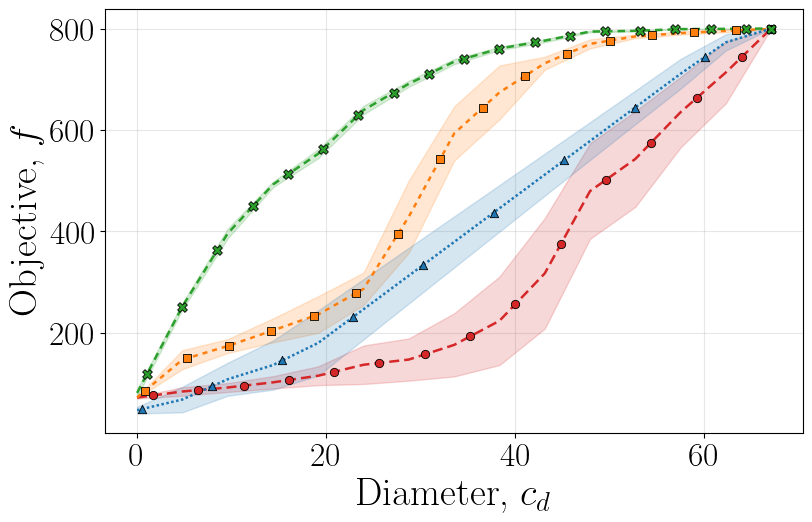

2026-02-07 23:49:47,335 |INFO: \\dataset{Yelp_Phoenix} & 9.829 & 11.948 & 10.301 & 0.813 \\
2026-02-07 23:49:47,338 |INFO: \\dataset{Yelp_Phoenix} & 961.100 & 15.000 & 776.700 & 9.500 \\


In [4]:
# Import Yelp Phoenix dataset
data_path = '../../datasets/pickled_data/yelp/yelp_phoenix_'
phoenix_ids, phoenix_simMatrix = import_yelp_data(data_path)
with open(data_path + 'graphMat.pkl', 'rb') as f:
    phoenix_graphMat = pickle.load(f)

# Adjust parameters as needed
sample_size = 800
num_samples = 10
findApproximateParetoSolutionsRestaurantsGraph(phoenix_simMatrix, phoenix_graphMat, phoenix_ids, sample_size, num_samples, dataset_name="Yelp_Phoenix")

### Yelp Vegas Experiments

2026-02-07 23:49:47,351 |INFO: Imported Yelp ids, Num Items: 3103
2026-02-07 23:49:47,374 |INFO: Imported Yelp similarity matrix, Shape: (3103, 3103)
2026-02-07 23:49:47,420 |INFO: Initialized Pareto Restaurants - Graph Cost Instance, Num Items:1200
2026-02-07 23:50:19,255 |INFO: ParetoGreedyDiameter finished: max_objective=1200.000, runtime=31.833s, items=1200
2026-02-07 23:50:57,013 |INFO: PlainGreedyDistanceScaled finished: max_objective=1198.834, runtime=29.645s
2026-02-07 23:51:00,146 |INFO: TopKDistanceScaled finished: max_objective=1200.000, runtime=3.003s
2026-02-07 23:51:37,847 |INFO: GraphPruning finished: max_objective=1200.000, runtime=37.700s
2026-02-07 23:51:37,899 |INFO: Initialized Pareto Restaurants - Graph Cost Instance, Num Items:1200
2026-02-07 23:52:10,336 |INFO: ParetoGreedyDiameter finished: max_objective=1200.000, runtime=32.435s, items=1200
2026-02-07 23:52:47,217 |INFO: PlainGreedyDistanceScaled finished: max_objective=1198.854, runtime=29.341s
2026-02-07 23:5

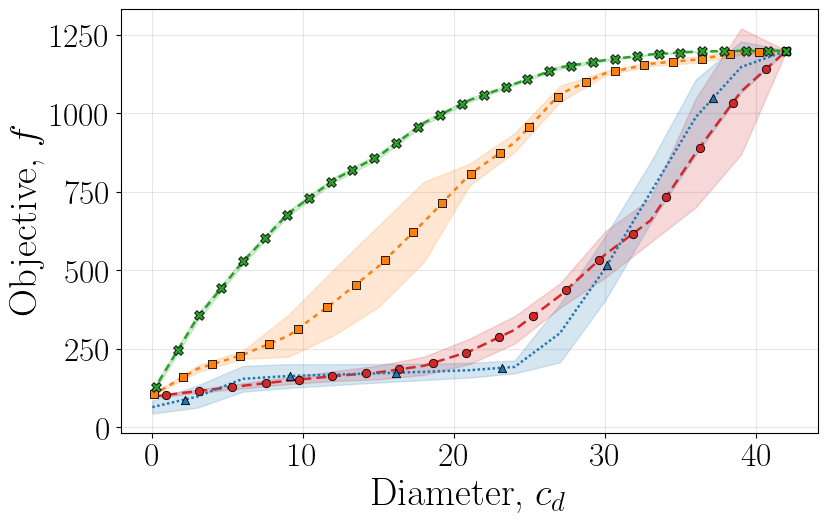

2026-02-08 00:08:07,140 |INFO: \\dataset{Yelp_Vegas} & 33.286 & 37.374 & 29.027 & 2.788 \\
2026-02-08 00:08:07,141 |INFO: \\dataset{Yelp_Vegas} & 1495.200 & 19.900 & 1149.900 & 7.100 \\


In [5]:
# Import Yelp Vegas dataset
data_path = '../../datasets/pickled_data/yelp/yelp_vegas_'
vegas_ids, vegas_simMatrix = import_yelp_data(data_path)
with open(data_path + 'graphMat.pkl', 'rb') as f:
    vegas_graphMat = pickle.load(f)

# Adjust parameters as needed
sample_size = 1200
num_samples = 10
findApproximateParetoSolutionsRestaurantsGraph(vegas_simMatrix, vegas_graphMat, vegas_ids, sample_size, num_samples, dataset_name="Yelp_Vegas")